## Load required modules.

In [1]:
%matplotlib widget
# Import ncessary modules.
from sklearn.decomposition import PCA
import xlrd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ipywidgets 
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from matplotlib import pyplot
from IPython.display import display, clear_output, Javascript
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.pipeline import Pipeline
import gc
import psutil

#from memory_profiler import memory_usage

def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)

import customtkinter as ctk


In [2]:
# window = ctk.CTk()

# #window
# window.title('MineralAI')
# window.geometry('1100x800')

# #widgets


# window.mainloop()

## Read EXCEL data file into data frame.

In [3]:
memory_0 = get_memory_usage()

# File path to your Excel file.
file_path = 'Geochemistry Results-AGG reduced variables.xlsx'

# Define the sheet name to read.
sheet_name = 'Litogeochemistry - clean'

df = pd.read_excel(file_path, sheet_name=sheet_name)

#Select lithologies for PCA analysis
lithologies = df['Lithology'].unique()
lithology_dropdown = widgets.SelectMultiple(
    options=lithologies,
    value = []
)

output = widgets.Output()

def filter_dataframe(change):
    global filtered_df
    selected = change['new']
    with output:
        clear_output(wait=True)
        filtered_df = df[df.iloc[:, 3].isin(selected)]
        display(filtered_df)

lithology_dropdown.observe(filter_dataframe, 'value')


print ("Hold command to deselect, or command A to select all")
display(lithology_dropdown)
display(output)

print(f"Initial Memory Usage: {memory_0:.2f} MB")
memory_0_01 = get_memory_usage()
print(f"Memory Usage first cell: {memory_0_01:.2f} MB")

Hold command to deselect, or command A to select all


SelectMultiple(options=('Di-Tr dolomitic marble', 'Dolomitic marble', 'Calcitic marble', 'Pure Siliciclastic',…

Output()

Initial Memory Usage: 236.58 MB
Memory Usage first cell: 250.02 MB


In [5]:
#procees botton still prototype
proceed_button = widgets.Button(description="Proceed")

def on_proceed_button_clicked(b):
    b.description = "Proceeding..."
    b.disabled = False
    Javascript("Jupyter.notebook.execute_cells()")

proceed_button.on_click(on_proceed_button_clicked)
display(proceed_button)

filtered_df.head()

Button(description='Proceed', style=ButtonStyle())

,Sample Description,Year,Depth(meters),Lithology,Shape,Comment,PTS,Al2O3_pct,BaO_pct,CaO_pct,...,Cd_ppm,Co_ppm,Cu_ppm,Li_ppm,Mo_ppm,Ni_ppm,Pb_ppm,Zn_ppm,C_pct,S_pct
0,S10-01,2022,4.44,Di-Tr dolomitic marble,Marble Units,NaN,No,0.73,0.02,26.7,...,0.25,4.0,10,20,1.0,6.0,4,27,7.22,0.23
1,S10-02,2022,14.49,Dolomitic marble,Marble Units,NaN,No,0.68,0.08,30.3,...,0.25,2.0,9,20,1.0,5.0,6,22,9.99,0.75
2,S10-03,2022,15.74,Dolomitic marble,Marble Units,NaN,No,0.56,0.01,29.4,...,0.25,1.0,5,10,1.0,4.0,3,23,10.55,0.58
3,S10-04,2022,26.80,Calcitic marble,Marble Units,NaN,Yes,0.92,0.04,37.0,...,0.25,0.5,4,20,1.0,3.0,10,31,7.76,0.26
4,S10-05,2022,27.02,Calcitic marble,Marble Units,NaN,Yes,3.18,0.08,35.4,...,0.25,3.0,9,10,1.0,7.0,4,13,7.79,1.22


In [6]:
filtered_df.shape

(103, 66)

## Remove symbols "<" and "NaN".

In [7]:
df = filtered_df.iloc[: , 7:].replace('\<','',regex=True).astype(float)
df = df[np.isfinite(df).all(1)].dropna()
df.head()

memory_0_1 = get_memory_usage()
print(f"Memory Usage After Filter: {memory_0_1:.2f} MB")

Memory Usage After Filter: 496.91 MB


In [8]:
df.shape

(103, 59)

## Scale data and apply PCA.

In [9]:
from sklearn.preprocessing import FunctionTransformer

# Scale data before applying PCA
#scaling=StandardScaler()
scaling = FunctionTransformer(np.log10, validate=True)

try:
    # Use fit and transform method 
    scaling.fit(df)
    Scaled_data=scaling.transform(df)
    Scaled_df = pd.DataFrame(Scaled_data)
    
    #Set the n_components
    pca=PCA(n_components=6)
    pca.fit(Scaled_data)
    x=pca.transform(Scaled_data)
     
    # Check the dimensions of data after PCA
    print(x.shape)
except:
    raise ValueError ('Not enough components for PCA. Please select more!')


print(Scaled_df)
print(df)


(103, 6)
           0         1         2         3         4         5         6   \
0   -0.136677 -1.698970  1.426511 -0.142668 -0.698970  1.271842 -1.221849   
1   -0.167491 -1.096910  1.481443  0.158362 -0.552842  1.258877 -0.958607   
2   -0.251812 -2.000000  1.468347  0.089905 -1.301030  1.287802 -1.000000   
3   -0.036212 -1.397940  1.568202 -0.229148 -0.769551  1.008600 -1.301030   
4    0.502427 -1.096910  1.549003  0.250420 -1.045757  0.726727 -1.301030   
..        ...       ...       ...       ...       ...       ...       ...   
98   1.117271 -1.522879  0.745075  0.835056 -0.494850  0.577492 -1.698970   
99   1.125481 -1.522879  0.578639  0.973590 -0.677781  0.502427 -1.698970   
100 -0.677781 -0.769551  1.451786 -0.638272 -0.886057  1.255273 -1.301030   
101 -1.096910 -1.698970  1.514548 -0.698970 -1.698970  1.275311 -1.301030   
102 -0.443697 -1.698970  1.482874 -0.585027 -0.698970  1.293363 -1.221849   

           7         8         9   ...       49        50        5

## Create a datafram for PCA componenets and scale it.

In [10]:
# Create dataframe
pca_df = pd.DataFrame(
    data=x, 
    #columns=['PC1', 'PC2', 'PC3'])
    columns=['PC'+str(i) for i in range(1, len(pca.components_)+1)])
pca_df
print(len(pca_df.columns))

6


In [11]:
# Create the scaled PCA dataframe
pca_df_scaled = pca_df.copy()
  
scaler_df = pca_df[pca_df.columns]
scaler = 1 / (scaler_df.max() - scaler_df.min())
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

memory_0_2 = get_memory_usage()
print(f"Memory Usage After PCA: {memory_0_2:.2f} MB")

Memory Usage After PCA: 497.53 MB


## Display loadings.

In [12]:
#loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=df.columns)
loadings = pd.DataFrame(pca.components_.T, columns=['PC'+str(i) for i in range(1, len(pca.components_)+1)], index=df.columns)

memory_0_3 = get_memory_usage()
print(f"Memory Usage After loadings: {memory_0_3:.2f} MB")

loadings

Memory Usage After loadings: 497.53 MB


,PC1,PC2,PC3,PC4,PC5,PC6
Al2O3_pct,0.237239,-0.066570,0.038657,-0.167366,-0.074680,0.045372
BaO_pct,0.071747,0.011751,0.151195,0.158058,0.158728,0.453725
CaO_pct,-0.070955,0.027873,0.043204,0.059932,0.079137,-0.089997
Fe2O3_pct,0.111979,0.077703,-0.090248,-0.093746,-0.005210,-0.111089
K2O_pct,0.176071,0.047979,0.271757,-0.069804,-0.103414,0.039165
MgO_pct,-0.065906,0.057457,0.116270,-0.016320,-0.010272,-0.072715
MnO_pct,-0.054844,0.088462,0.023561,0.071261,0.015359,-0.104579
Na2O_pct,0.193191,-0.105348,-0.086027,-0.179936,-0.072657,0.176474
P2O5_pct,0.097300,0.129126,0.019646,-0.014168,0.103179,-0.028636
SiO2_pct,0.089478,-0.117051,0.011090,-0.129689,-0.047946,0.174335


## Display sorted loadings.

In [13]:
# sorted_loadings = loadings.sort_values(by='PC1', ascending=False)  # Change 'ascending' as needed
# sorted_loadings

In [14]:
# sorted_loadings = loadings.sort_values(by='PC2', ascending=False)  # Change 'ascending' as needed
# sorted_loadings

In [15]:
# sorted_loadings = loadings.sort_values(by='PC3', ascending=False)  # Change 'ascending' as needed
# sorted_loadings

interactive(children=(Checkbox(value=False, description='Sort'), Output()), _dom_classes=('widget-interact',))

Memory Usage After PCA bar: 515.22 MB


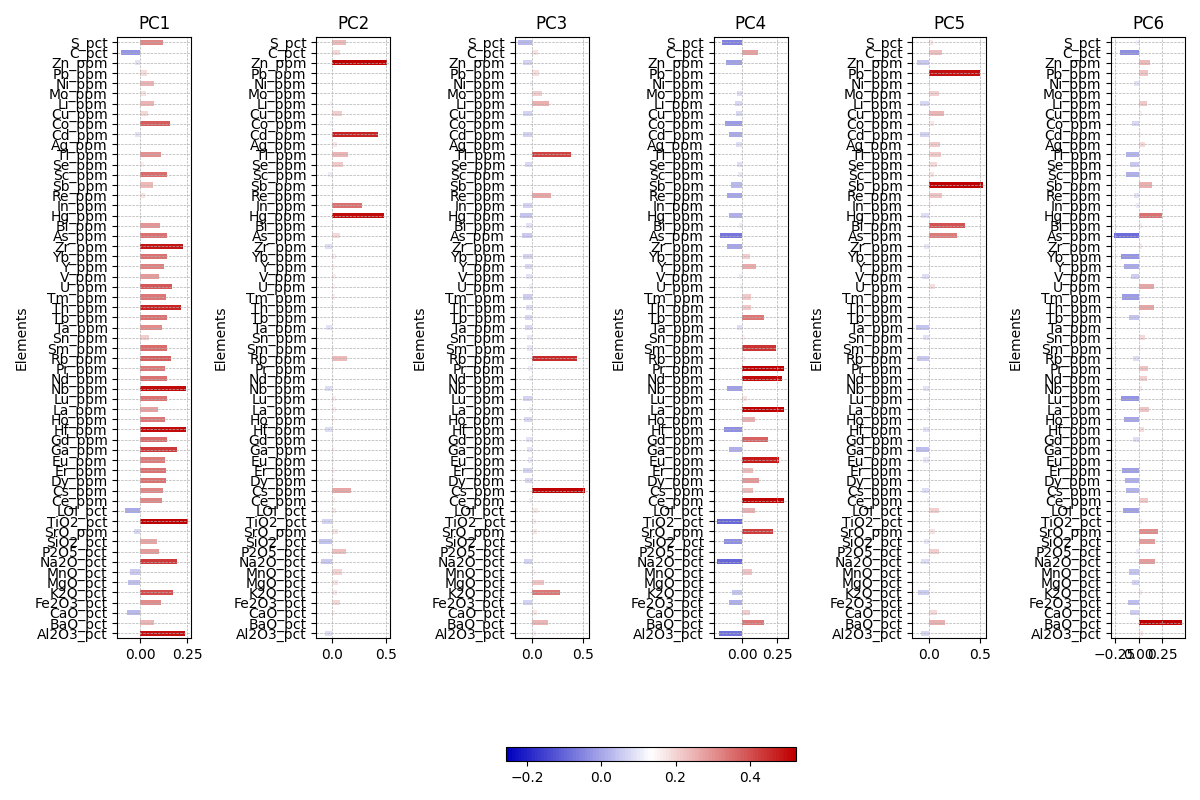

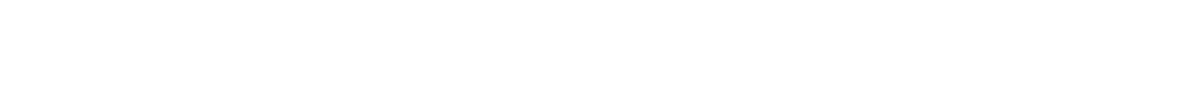

In [16]:
#create bar graph for the loadings PCA
colors = [(0, 0, 0.75), (1, 1, 1), (0.75, 0, 0)]
n_bins = 100
cmap_name = "PC map"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#normalize, nessesary for color range to function property
def normalize(values, vmin=None, vmax=None):
    vmin = vmin if vmin is not None else np.min(values)
    vmax = vmax if vmax is not None else np.max(values)
    norm_values = (values - vmin) / (vmax - vmin)
    return norm_values


def plot_pc_barchart(data, pc_name, ax, sort=False):
    if sort:
        data = data.sort_values(ascending=False)
    #colors = ['#1f77b4' if x > 0 else '#d62728' for x in sorted_loadings]
    norm_values = normalize(data, vmin=-max(abs(data)), vmax=max(abs(data)))
    bar_colors = cm(norm_values)
    data.plot(kind='barh', color=bar_colors, ax=ax)
    ax.set_title(pc_name)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('Elements')


def update_plots(sort):
    plt.close('all')
    fig, axes = plt.subplots(ncols=len(loadings.columns), figsize=(12, 8))

    for i in range (len(loadings.columns)):
        plot_pc_barchart(loadings[f'PC{i+1}'], f'PC{i+1}', axes[i], sort)

    plt.tight_layout()

    fig_c = plt.figure(figsize=(12, 1))

    min_val = loadings.min().min()
    max_val = loadings.max().max()

    norm = plt.Normalize(vmin=min_val, vmax=max_val)
    cbar = fig_c.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cm), ax = axes, orientation='horizontal', fraction = 0.02)


interact(update_plots, sort=widgets.Checkbox(value=False, description='Sort'))

plt.tight_layout()

memory_0_4 = get_memory_usage()
print(f"Memory Usage After PCA bar: {memory_0_4:.2f} MB")

## Plot a 3D scatter plot with arrows for PCA directions.

In [17]:
#create color map
dc = filtered_df['Lithology']

dc = dc.to_frame()
dc = dc.rename(columns={dc.columns[0]: 'Lithology'})

# color_list = dc['Lithology'].unique()

# default_colors = ["lime", "blue", "cyan", "deeppink", "pink", "black", "black", "black", "grey", "lightgrey"]

# color_map = {}

# # Populate the dictionary with symbols for each shape
# for i, color in enumerate(color_list):
#     if i < len(default_colors):
#         color_map[color] = default_colors[i]


color_map = {
    'Calcitic marble': 'lime',
    'Dolomitic marble': 'blue',
    'Di-Tr dolomitic marble': 'cyan',
    'Carbonatite': 'deeppink',
    'Carbonatite-like': 'pink',
    'Syenite': 'black',
    'Altered Syenite': 'black',
    'Syenite-like': 'black',
    'Impure Siliciclastic': 'grey',
    'Pure Siliciclastic': 'lightgrey'
}

dc['Color'] = dc['Lithology'].map(color_map)

dc=dc.replace('\<','NaN',regex=True)
dc = dc.dropna()

print(dc)
#print (pca_df_scaled)
print("Shape of y:", dc.shape)
#print("Shape of X:", X.shape)


                  Lithology      Color
0    Di-Tr dolomitic marble       cyan
1          Dolomitic marble       blue
2          Dolomitic marble       blue
3           Calcitic marble       lime
4           Calcitic marble       lime
..                      ...        ...
98       Pure Siliciclastic  lightgrey
99       Pure Siliciclastic  lightgrey
100  Di-Tr dolomitic marble       cyan
101        Dolomitic marble       blue
102        Dolomitic marble       blue

[103 rows x 2 columns]
Shape of y: (103, 2)


In [18]:
#create shape map
ds = filtered_df.iloc[:, 4]
ds = ds.to_frame()
ds = ds.rename(columns={ds.columns[0]: 'Shape'})

# shape_list = ds['Shape'].unique()

# default_symbols = ["^", "*", "o", "s", "D"]

# color_map1 = {}

# # Populate the dictionary with symbols for each shape
# for i, shape in enumerate(shape_list):
#     if i < len(default_symbols):
#         color_map1[shape] = default_symbols[i]

color_map1 = {
    'Marble Units': "^",
    'Altered Intrusion': "*",
    'Siliciclastic': "o",
    'Intrusion': "s",
    'Anamolous Rock': "D",
}

ds["Shapes"] = ds["Shape"].map(color_map1)

ds=ds.replace('\<','NaN',regex=True)
ds = ds.dropna()

print(ds)
#print (pca_df_scaled)
print("Shape of y:", ds.shape)
#print("Shape of X:", X.shape)

memory_0_5 = get_memory_usage()
print(f"Memory Usage After ds dc: {memory_0_5:.2f} MB")

             Shape Shapes
0     Marble Units      ^
1     Marble Units      ^
2     Marble Units      ^
3     Marble Units      ^
4     Marble Units      ^
..             ...    ...
98   Siliciclastic      o
99   Siliciclastic      o
100   Marble Units      ^
101   Marble Units      ^
102   Marble Units      ^

[103 rows x 2 columns]
Shape of y: (103, 2)
Memory Usage After ds dc: 567.06 MB


interactive(children=(Checkbox(value=False, description='Show_Shape'), Output()), _dom_classes=('widget-intera…

interactive(children=(Dropdown(description='Legend', options=(('Shapes Legend', True), ('Lithology Legend', Fa…

interactive(children=(Checkbox(value=False, description='Show all Names'), Output()), _dom_classes=('widget-in…

interactive(children=(Checkbox(value=False, description='Show all Arrows'), Output()), _dom_classes=('widget-i…

Press Command to Select Multiple


SelectMultiple(description='Select multiple items:', options=('Al2O3_pct', 'BaO_pct', 'CaO_pct', 'Fe2O3_pct', …

Memory Usage initial 3d: 628.05 MB
Memory Usage After 3d Plot: 631.52 MB
Memory Usage After Deletion: 631.52 MB


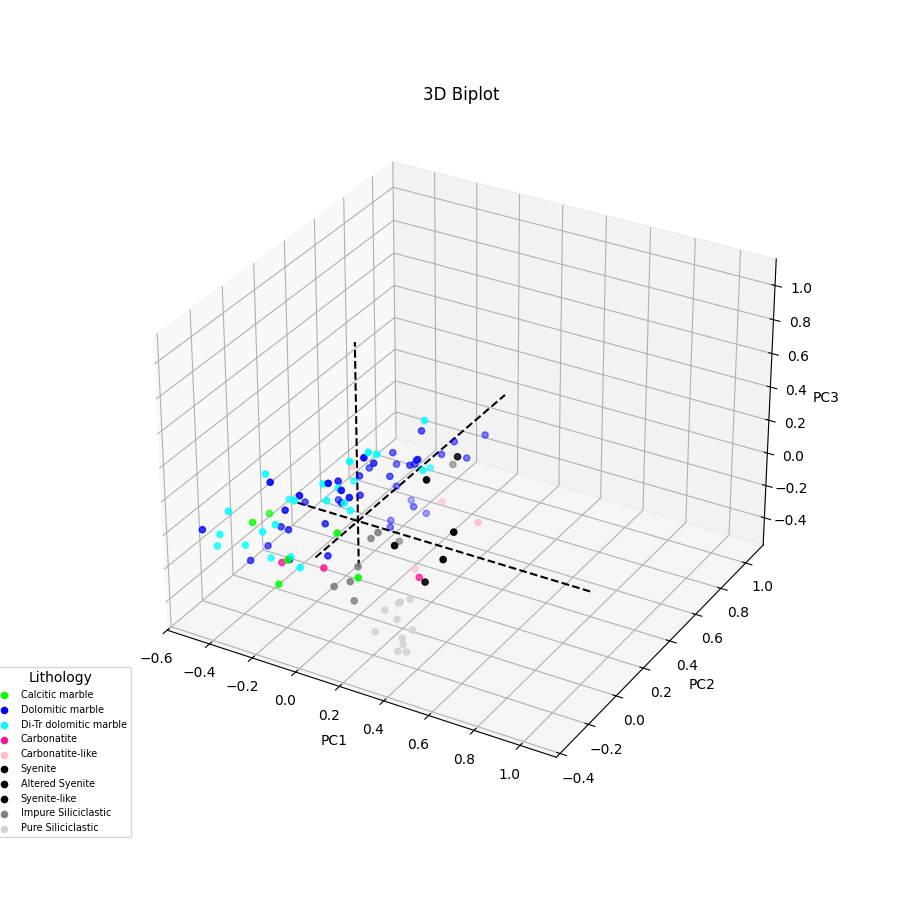

In [20]:
memory_1 = get_memory_usage()

# Initialize the 3D graph
plt.close('all')
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
  
# Define scaled features as arrays
xdata = pca_df_scaled['PC1']
ydata = pca_df_scaled['PC2']
zdata = pca_df_scaled['PC3']

# Plot 3D scatterplot of PCA

#df = pd.read_excel(file_path, sheet_name=sheet_name)
#description = df.iloc[:, 0]

#descriptions = []
dc.reset_index(drop=True, inplace=True)
ds.reset_index(drop=True, inplace=True)


#show shape
shapes1 = []
for i in range(len(filtered_df)):
    #print(f"Index {i}: Color {dc['Color'][i]}, Shape {ds['Shapes'][i]}")  # Debug print
    shape1 = ax.scatter3D(xdata[i], ydata[i], zdata[i], c=dc['Color'][i], marker=ds["Shapes"][i])
    shapes1.append(shape1)
    #text = ax.text(xdata[i], ydata[i], zdata[i], description[i], size=10, zorder=1, color='k')
    #descriptions.append(text)

dots = ax.scatter3D(xdata, ydata, zdata, c=dc['Color'])
dots.set_visible(True)

def shape(Show_Shape):
    if Show_Shape:
        for shape1 in shapes1:
            shape1.set_visible(True)  
        dots.set_visible(False) 
    else:
        dots.set_visible(True)
        for shape1 in shapes1:
            shape1.set_visible(False)

interact(shape, Show_Shape=False)


#create legend
handle1 = []
label1 = []
for lithology, color in color_map.items():
    l1 = ax.scatter([], [], c=color, label=lithology)
    handle1.append(l1)
    label1.append(lithology)

handle2 = []
label2 = []
for shape, shapes in color_map1.items():
    l2 = ax.scatter([], [], c="black", marker=shapes, label=shape)
    handle2.append(l2)
    label2.append(shape)

legend1 = pyplot.legend(handle1, label1, bbox_to_anchor=(0.03, 0.2), title='Lithology', fontsize='x-small')
legend2 = pyplot.legend(handle2, label2, bbox_to_anchor=(0.03, 0.2), title='Shapes', fontsize='x-small')
ax.add_artist(legend1)
ax.add_artist(legend2)

def legenda(Legend):
    if Legend:
        legend1.set_visible(True)  
        legend2.set_visible(False)
    else:
        legend1.set_visible(False)
        legend2.set_visible(True)
interact(legenda, Legend=[('Shapes Legend', True),('Lithology Legend', False)])


#set up loadings
show_names=df.columns.tolist()
indx=df.columns.get_indexer(show_names)
scale=2

# Define the x, y, z variables
loadings_1 = pca.components_
xs = scale*loadings_1[0]
ys = scale*loadings_1[1]
zs = scale*loadings_1[2]  
# Plot title of graph
plt.title(f'3D Biplot')
  
# Plot x, y, z labels
ax.set_xlabel('PC1')#, rotation=150)
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')#, rotation=60)
#plt.savefig('3D_biplot.svg')



# Plot the arrows
arrow_list = []
x_arr = np.zeros(len(loadings_1[0]))
y_arr = z_arr = x_arr

#show_arrows = ax.quiver(x_arr[indx], y_arr[indx], z_arr[indx], xs[indx], ys[indx], zs[indx],color='r')
for i, name in enumerate(df.columns):
    ip = df.columns.get_loc(name)
    arrow = ax.quiver(x_arr[ip], y_arr[ip], z_arr[ip], xs[ip], ys[ip], zs[ip], color='r', arrow_length_ratio = 0.1, linewidth=0.5)
    arrow_list.append(arrow)
    
def findarrow(change):
    if change: 
        for a in arrow_list:
            a.set_visible(True)
    else:
        for a in arrow_list:
            a.set_visible(False)


#plot the axis
all_points = np.concatenate((xs, ys, zs))
min_value = np.min(all_points)
max_value = np.max(all_points)

axis_range = [min_value, max_value]

ax.plot([x_arr.any() + axis_range[0], x_arr.any() + axis_range[1]], [y_arr.any(), y_arr.any()], [z_arr.any(), z_arr.any()], color='k', linestyle='--')
ax.plot([x_arr.any(), x_arr.any()], [y_arr.any() + axis_range[0], y_arr.any() + axis_range[1]], [z_arr.any(), z_arr.any()], color='k', linestyle='--') 
ax.plot([x_arr.any(), x_arr.any()], [y_arr.any(), y_arr.any()], [z_arr.any() + axis_range[0], z_arr.any() + axis_range[1]], color='k', linestyle='--')




# Plot the loadings
namelist = []

for i , names in enumerate(show_names):
    ip=indx[i]
    #ax.scatter(xs[ip], ys[ip], zs[ip], s=100)
    n = ax.text(xs[ip]+0.02, ys[ip]+0.02, zs[ip]+0.02, names, fontsize='small')
    namelist.append(n)

show_name_checkbox = widgets.Checkbox(value=False, description='Show all Names')
all_arrow_checkbox = widgets.Checkbox(value=False, description='Show all Arrows')

def findname(show_name):
    if show_name:
        for n in namelist:
            n.set_visible(True)  
    else:
        for n in namelist:
            n.set_visible(False)


#create multiselection list for individual elements
def findname_specific(change):
    selected_items = change['new']
    # if 'all' in selected_items:
    #     select_multiple.value = options
    #     for n in namelist:
    #         n.set_visible(True)
    #     for arrow in arrow_list:
    #         arrow.set_visible(True)
    # else:
    for i in range(len(options[:])):  
        if options[i] in selected_items:
            namelist[i].set_visible(True)
            arrow_list[i].set_visible(True)
        else:
            namelist[i].set_visible(False)
            arrow_list[i].set_visible(False)
    show_name_checkbox.value = False
    all_arrow_checkbox.value = False
plt.draw()

interact(findname, show_name=show_name_checkbox)
interact(findarrow, change=all_arrow_checkbox)

options = df.columns.tolist()

select_multiple = widgets.SelectMultiple(
    options=options,
    value=[],
    description='Select multiple items:'
)
select_multiple.observe(findname_specific, 'value')
print ('Press Command to Select Multiple')

display(select_multiple)


#memory
memory_2 = get_memory_usage()
gc.collect()
memory_3 = get_memory_usage()

print(f"Memory Usage initial 3d: {memory_1:.2f} MB")
print(f"Memory Usage After 3d Plot: {memory_2:.2f} MB")
print(f"Memory Usage After Deletion: {memory_3:.2f} MB")


In [ ]:
#prediction
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# try:
#     y = dc['Lithology']
#     y = y.values.ravel()
#     X = pca_df_scaled
#     print("Shape of y:", y.shape)
#     print("Shape of X:", X.shape)
    
#     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     clf.fit(X, y)
    
#     print(clf.predict([[0.3, -0.01, 0.1]]))
# except:
#     print ("need more litho group")

# memory_4 = get_memory_usage()
# print(f"Memory Usage After predict: {memory_4:.2f} MB")

In [ ]:
fig = plt.figure(figsize=(10, 9))

# create 2d plot for each PC set
def planes (options):
    #create graph and legend
    plt.clf()
    ax1 = fig.add_subplot(111)
    handle3 = []
    label3 = []
    for lithology, color in color_map.items():
        l3 = ax1.scatter([], [], c=color, label=lithology)
        handle3.append(l3)
        label3.append(lithology)
    
    handle4 = []
    label4 = []
    for shape, shapes in color_map1.items():
        l4 = ax1.scatter([], [], c="black", marker=shapes, label=shape)
        handle4.append(l4)
        label4.append(shape)
        
    legend3 = ax1.legend(handle3, label3, title='Lithology', fontsize='x-small')
    legend4 = ax1.legend(handle4, label4, loc = "lower left", title='Shapes', fontsize='x-small')
    ax1.add_artist(legend3)
    ax1.add_artist(legend4)
    
    
    #show shape checkbox
    xdata = pca_df_scaled[options[0]]
    ydata = pca_df_scaled[options[1]]
    
    shapes2 = []
    for i in range(len(df)):
        shape2 = plt.scatter(xdata[i], ydata[i], c=dc['Color'][i], marker=ds["Shapes"][i])
        shapes2.append(shape2)
    
    dots2 = plt.scatter(xdata, ydata, c=dc['Color'])
    dots2.set_visible(True)
    
    def shape(Show_Shape):
        if Show_Shape:
            for shape2 in shapes2:
                shape2.set_visible(True)  
            dots2.set_visible(False) 
        else:
            dots2.set_visible(True)
            for shape2 in shapes2:
                shape2.set_visible(False)
    
    interact(shape, Show_Shape=False)
    


    #set up names and location
    show_names=df.columns.tolist()
    indx=df.columns.get_indexer(show_names)
    
    
    loadings = pca.components_
    xs = loadings[options[2]]
    ys = loadings[options[3]]
    
    
    #Plot the arrows
    arrow_list_2d = []
    
    x_arr = np.zeros(len(loadings[0]))
    y_arr = x_arr

    plt.axhline(y=y_arr.any(), color='k', linestyle='--')
    plt.axvline(x=x_arr.any(), color='k', linestyle='--')
    
    arrow_scale=1.2
    
    for i, name in enumerate(df.columns):
        ip = df.columns.get_loc(name)
        arrow_2d = plt.quiver(x_arr[ip], y_arr[ip], xs[ip], ys[ip], color='r', scale = arrow_scale, width = 0.002)
        arrow_list_2d.append(arrow_2d)
        
    namelist_2d = []
    for i , names in enumerate(show_names):
        ip=indx[i]
        #ax.scatter(xs[ip], ys[ip], zs[ip], s=100)
        n = plt.text((1)*xs[ip], (1)*ys[ip], names, fontsize='small')
        #n = plt.text(xs[ip], ys[ip], names, fontsize='small')
        namelist_2d.append(n)

    # def findname_2d(show_name):
    #     if show_name:
    #         for n in namelist_2d:
    #             n.set_visible(True)  
    #     else:
    #         for n in namelist_2d:
    #             n.set_visible(False)
        
    # def findarrow_2d(Visibility_arrow):
    #     if Visibility_arrow: 
    #         for a in arrow_list_2d:
    #             a.set_visible(True)
    #     else:
    #         for a in arrow_list_2d:
    #             a.set_visible(False)

    
    # show_name_checkbox = widgets.Checkbox(value=False, description='Show all Names')
    # all_arrow_checkbox = widgets.Checkbox(value=False, description='Show all Arrows')
    
    #create multiselection list for individual elements
    def findname_specific_2d(change):
        selected_items = change['new']
        for i in range(len(options_ele[:])): 
            if options_ele[i] in selected_items:
                namelist_2d[i].set_visible(True)
                arrow_list_2d[i].set_visible(True)
            else:
                namelist_2d[i].set_visible(False)
                arrow_list_2d[i].set_visible(False)
        show_name_checkbox.value = False
        all_arrow_checkbox.value = False
    plt.draw()
    
    # interact(findname_2d, show_name=show_name_checkbox)
    # interact(findarrow_2d, Visibility_arrow=all_arrow_checkbox)
    
    options_ele = df.columns.tolist()
    
    select_multiple = widgets.SelectMultiple(
        options=options_ele,
        value=[],
        description='Select multiple items:'
    )
    select_multiple.observe(findname_specific_2d, 'value')
    print ('Press Command to Select Multiple')
    
    display(select_multiple)
    plt.xlabel(options[0])
    plt.ylabel(options[1])
    plt.title(f"{options[0]} vs {options[1]}")


#create a combination of PC sets
list_plane = []
for j in range (len(pca_df.columns)):
    for i in range (j+1, len(pca_df.columns)):
        list_plane.append((f'PC{j+1} vs PC{i+1}', [f'PC{j+1}', f'PC{i+1}', j, i]))
                    
widgets.interact(planes, options = list_plane)
memory_5 = get_memory_usage()

print(f"Memory Usage After 2d PC: {memory_5:.2f} MB")

In [ ]:
# # import relevant libraries for 3d graph
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(10,10))
 
# # choose projection 3d for creating a 3d graph
# axis = fig.add_subplot(111, projection='3d')
 
# # x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
# img=axis.scatter(x[:,0],x[:,1],x[:,2], c=df['Zn_ppm'])

# # Plot the loadings
# for i in range(5):
#     axis.scatter(xs[i], ys[i], zs[i], s=200)
#     #axis.text(
#     #    xs[i] + 0.1, 
#     #    ys[i] + 0.1, 
#     #    zs[i] + 0.1, 
#     #    varnames)
  
# # Plot the arrows
# x_arr = np.zeros(len(loadings[0]))
# y_arr = z_arr = x_arr
# axis.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

# axis.set_xlabel("PC1")
# axis.set_ylabel("PC2")
# axis.set_zlabel("PC3")
# fig.colorbar(img)

In [ ]:
# Remove all rows that have at least one NaN.
df = df.dropna()

max_Zn = df['Zn_ppm'].max()
min_Zn = df['Zn_ppm'].min()

def cluster_2d(axis1, axis2):
    global df
    if axis1 != axis2:
        # Remove "<" from the values.
        df[axis1] = df[axis1].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
        df[axis2] = df[axis2].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
        
        # Change to "object" to "float".
        df[axis1] = df[axis1].astype(float)
        df[axis2] = df[axis2].astype(float)
        
        
        # Set the data for clustering
        X = df[[axis1, axis2]].values
        
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)
        dd = pd.read_excel(file_path, sheet_name=sheet_name)
        
        #scaler and model
        def update_kmeans(k):    
            pipe = Pipeline([
            ("scale", StandardScaler()),
            ("model", KMeans(n_clusters=k, random_state = 0, n_init='auto'))])
        
            pipe.fit(X)
        
            # Add cluster labels to the DataFrame
            df['cluster'] = pipe.named_steps['model'].labels_

            #create meshgrid for background coloring
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
            
            #predict cluster for each point in the meshgrid
            Z = pipe.named_steps['model'].predict(pipe.named_steps['scale'].transform(np.c_[xx.ravel(), yy.ravel()]))
            Z = Z.reshape(xx.shape)

            #draw
            plt.figure(figsize=(9, 7))
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.2)

            #create a size chart corrisponding to the value of Zn_ppm and plot
            def map_size(x, new_min, new_max):
                old_min = min_Zn
                old_max = max_Zn
                return ((np.log(x + 1) - np.log(old_min + 1)) / (np.log(old_max + 1) - np.log(old_min + 1))) * (new_max - new_min) + new_min
            
            sns.scatterplot(data=df, x=axis1, y=axis2, c=dc['Color'], s=df['Zn_ppm'].apply(lambda x: map_size(x, 20, 100)))# change the last two values if want to change size range of point
        
            #plot the sample names
            df.apply(lambda row: plt.text(row[axis1], row[axis2] + 0.1, dd.iloc[row.name, 0], fontsize=7, ha='center'), axis=1)
        
            #plot the controids
            scaler = pipe.named_steps['scale']
            centroids = pipe.named_steps['model'].cluster_centers_
            centroids_original = scaler.inverse_transform(centroids)
        
            plt.scatter(centroids_original[:,0], centroids_original[:,1], 
                    marker="X", c="red", s=30, label="centroids")
            
            plt.legend()
            plt.title("K-Means Clustering")
            plt.show()
            
        #create interact slider for k
        interact(update_kmeans, k = IntSlider(min=2, max=10, step=1, description='N Clusters'))
    else:
        #debugging if two selection the same
        print ('select two different elements')

#creating the dropdown of elements
interact(cluster_2d, 
         axis1=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[32], description='Axis1'), 
         axis2=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[34], description='Axis2'))

memory_6 = get_memory_usage()
print(f"Memory Usage After 2d cluster: {memory_6:.2f} MB")


In [ ]:
# Remove all rows that have at least one NaN.
df = df.dropna()
dd = pd.read_excel(file_path, sheet_name=sheet_name)

def cluster_3d(axis1, axis2, axis3):
    global df
    #make sure three elements are different
    if axis1 != axis2 and axis1 != axis3 and axis2 != axis3:
        #cleaning
        for col in [axis1, axis2, axis3]:
            df[col] = df[col].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
        df = df.astype({axis1: 'float', axis2: 'float', axis3: 'float'})

        # Set the data for clustering
        X = df[[axis1, axis2, axis3]].values
        
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)
        
        #scaler and model
        def update_kmeans(k=3):
            pipe = Pipeline([
                ("scale", StandardScaler()),
                ("model", KMeans(n_clusters=k, random_state=0, n_init='auto'))
            ])
            pipe.fit(X)

            # Add cluster labels to the DataFrame
            df['cluster'] = pipe.named_steps['model'].labels_
        
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            #plot the data points
            scatter = ax.scatter(df[axis1], df[axis2], df[axis3], c=df['cluster'], cmap='viridis', s=10)
            df.apply(lambda row: ax.text(row[axis1], row[axis2], row[axis3], dd.iloc[row.name, 0], fontsize=7, ha='center'), axis=1)
        
        
            # Plot the centroids
            scaler = pipe.named_steps['scale']
            centroids = pipe.named_steps['model'].cluster_centers_
            centroids_original = scaler.inverse_transform(centroids)
            
            ax.scatter(centroids_original[:, 0], centroids_original[:, 1], centroids_original[:, 2], 
                       marker="X", c="red", s=100, label="centroids")
        
            ax.set_xlabel(axis1)
            ax.set_ylabel(axis2)
            ax.set_zlabel(axis3)
            plt.legend()
            plt.title("3D K-Means Clustering")
            plt.show()
        
        interact(update_kmeans, k=IntSlider(min=2, max=10, step=1, description='N Clusters'))
    else:
        #debugging if two or more elements the same
        print ('select three different elements')

#create the dropdown for the elements
interact(cluster_3d, 
         axis1=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[0], description='Axis 1'), 
         axis2=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[2], description='Axis 2'), 
         axis3=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[4], description='Axis 3'))


memory_7 = get_memory_usage()
print(f"Memory Usage After 3d cluster: {memory_7:.2f} MB")


In [ ]:
            #3d background shading, use only if enough memory (mac impossible)
            # x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            # y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            # z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
            # xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50),
            #                          np.linspace(y_min, y_max, 50),
            #                          np.linspace(z_min, z_max, 50))
        
            # # Predict cluster labels for each point in the mesh grid
            # grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
            # grid_points_scaled = pipe.named_steps['scale'].transform(grid_points)
            # Z = pipe.named_steps['model'].predict(grid_points_scaled)
            # Z = Z.reshape(xx.shape)
        
            # ax.scatter(xx, yy, zz, c=Z, cmap='Pastel1', alpha=0.1)

In [ ]:
# Plot the distortion score elbow.
from yellowbrick.cluster import KElbowVisualizer

plt.figure(figsize=(10, 6))
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 12)).fit(X)
visualizer.show()